In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df=pd.read_csv('./Database/DB_v1.csv',index_col=False)
df=df.drop(['Unnamed: 0'],axis=1)
y=df['DEF_PAY']
X=df.drop(['DEF_PAY'],axis=1)
scaler=StandardScaler()
x=scaler.fit_transform(X)

[0.2576492  0.42812001 0.5002729  0.56648225 0.61213354 0.65620279
 0.69768136 0.73614753 0.77449353 0.81216816 0.846047   0.87781102
 0.90366544 0.92702742 0.94814481 0.962809   0.9741174  0.984842
 0.99302702 0.99610597 0.99788945 0.9989901  1.        ]


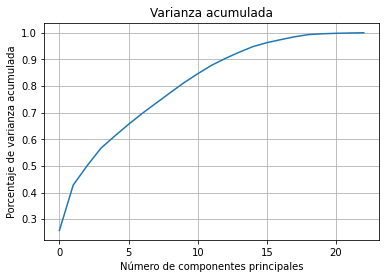

In [76]:
pca_varianza = PCA(n_components=X.shape[1]).fit(StandardScaler().fit_transform(X))
ALL_Componentes = np.cumsum(pca_varianza.explained_variance_ratio_)
print(ALL_Componentes)
plt.plot(np.cumsum(pca_varianza.explained_variance_/np.sum(pca_varianza.explained_variance_)))
plt.title('Varianza acumulada')
plt.xlabel('Número de componentes principales')
plt.ylabel('Porcentaje de varianza acumulada')
plt.grid()

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
import time
def entrenamiento_sin_seleccion_caracteristicas(splits, X, Y):

    Balan_Acc = np.ones(splits)
    roc_auc = np.ones(splits)
    times = np.ones(splits)
    j = 0
    skf = StratifiedKFold(n_splits=10)
    
    for train_index, test_index in skf.split(X,Y):
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = Y[train_index], Y[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        clf = MLPClassifier(activation='tanh', alpha=0.1, early_stopping=True,
              hidden_layer_sizes=100, max_iter=300)
        #Aquí se entran y se valida el modelo sin hacer selección de características
        tiempo_i = time.time()
        clf.fit(X_train,y_train)
        # Validación del modelo
        Yest=clf.predict_proba(X_test)
        Balan_Acc[j] = balanced_accuracy_score(y_true=y_test, y_pred=np.argmax(Yest,1))
        roc_auc[j]=roc_auc_score(y_test,Yest[:,1])
        times[j] = time.time()-tiempo_i
        j+=1

    return np.mean(Balan_Acc), np.std(Balan_Acc),np.mean(roc_auc), np.std(roc_auc), np.mean(times)

def entrenamiento_pca_ext_caracteristicas(splits,n_comp, X, Y):

    #Implemetamos la metodología de validación 
    Balan_Acc = np.ones(splits)
    roc_auc = np.ones(splits)
    times = np.ones(splits)
    j = 0
    skf = StratifiedKFold(n_splits=splits)
    for train_index, test_index in skf.split(X,Y):  
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # ¿es necesario estandarizacion de datos?
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
 
        #dejar el mismo nombre del objeto 
        pca = PCA(n_components= n_comp)
        # para calcular costo computacional
        tiempo_i = time.time()
        # es recomendable usar el metodo que ajusta y transforma
        X_train_pca = pca.fit_transform(X= X_train)
        # aca solo usar el metodo de transformar (ya que en el anterior el pca se ajusto)
        X_test_pca = pca.transform(X= X_test)
        # entrenar el modelo usando las caractieristicas transformadas por PCA
        clf = MLPClassifier(activation='tanh', alpha=0.1, early_stopping=True,
              hidden_layer_sizes=100, max_iter=300)
        clf.fit(X= X_train_pca, y=y_train)
        tiempo_o = time.time()-tiempo_i
        Yest=clf.predict_proba(X_test_pca)
        Balan_Acc[j] = balanced_accuracy_score(y_true=y_test, y_pred=np.argmax(Yest,1))
        roc_auc[j]=roc_auc_score(y_test,Yest[:,1])
        times[j] = tiempo_o
        j+=1


    return np.mean(Balan_Acc), np.std(Balan_Acc),np.mean(roc_auc), np.std(roc_auc), np.mean(times)

def experimentar_PCA(n_comp, X, Y):

    df = pd.DataFrame()
    idx = 0
    split_number = 10
    #Sin selección de características
    Acc,ic_Acc,ROC,ic_ROC,t_ex = entrenamiento_sin_seleccion_caracteristicas(split_number, X,Y)  
    df.loc[idx,'CON_EXTRA'] = 'NO'
    df.loc[idx,'NUM_COMP'] = X.shape[1] # se usan todas las caracteristicas
    df.loc[idx,'BALANCE_ACC'] = Acc
    df.loc[idx,'IC_ACC'] = ic_Acc
    df.loc[idx,'ROC_AUC'] = ROC
    df.loc[idx,'IC_ROC_AUC'] = ic_ROC
    df.loc[idx,'T_EJECUCION'] = t_ex
    idx+=1
    print("termina experimento sin selección")
    #Con selección de características
    
    for f in n_comp:
        #Implemetamos la metodología de validación 
        Acc,ic_Acc,ROC,ic_ROC,t_exx = entrenamiento_pca_ext_caracteristicas(splits=5,n_comp=f, X= X,Y=Y)
        df.loc[idx,'CON_EXTRA'] = 'SI'
        df.loc[idx,'NUM_COMP'] = f
        df.loc[idx,'BALANCE_ACC'] = Acc
        df.loc[idx,'IC_ACC'] = ic_Acc
        df.loc[idx,'ROC_AUC'] = ROC
        df.loc[idx,'IC_ROC_AUC'] = ic_ROC
        df.loc[idx,'T_EJECUCION'] = t_ex
        idx+=1
    return df

In [7]:
result=experimentar_PCA(n_comp=[12,15,17,18,20,21], X= np.array(X), Y = y)

termina experimento sin selección


In [10]:
result.sort_values(['ROC_AUC'],ascending=[False])

,CON_EXTRA,NUM_COMP,BALANCE_ACC,IC_ACC,ROC_AUC,IC_ROC_AUC,T_EJECUCION
0,NO,23.0,0.657734,0.018809,0.768703,0.018852,14.717428
6,SI,21.0,0.655314,0.011382,0.767729,0.016137,14.717428
4,SI,18.0,0.659402,0.009208,0.766732,0.018790,14.717428
5,SI,20.0,0.658027,0.016591,0.766191,0.019851,14.717428
2,SI,15.0,0.639710,0.011647,0.765712,0.023723,14.717428
3,SI,17.0,0.656803,0.013379,0.764036,0.015823,14.717428
1,SI,12.0,0.639829,0.016497,0.763263,0.017581,14.717428
